In [1]:
# Include Library
import os
import numpy as np
import pandas as pd
import librosa
import scipy.signal
import scipy.fftpack
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from scipy.fftpack import dct, fft
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def calculate_mfcc(audio, sample_rate=16000, num_mfcc=13, num_filters=26, frame_length=0.025, frame_stride=0.01):
    sr, audio = wav.read(audio)
    # Pre-emphasis
    pre_emphasis = 0.97
    emphasized_audio = np.append(audio[0], audio[1:] - pre_emphasis * audio[:-1])
    
    # Frame the signal
    frame_length, frame_step = int(frame_length * sample_rate), int(frame_stride * sample_rate)
    signal_length = len(emphasized_audio)
    num_frames = int(np.ceil(float(signal_length - frame_length) / frame_step))
    
    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized_audio, z)
    
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    
    # Apply Hamming window
    frames *= np.hamming(frame_length)
    
    # Compute the Fast Fourier Transform (FFT)
    NFFT = 512
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))
    
    # Compute the power spectrum
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))
    
    # Apply filter banks
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))
    mel_points = np.linspace(low_freq_mel, high_freq_mel, num_filters + 2)
    hz_points = (700 * (10**(mel_points / 2595) - 1))
    bin_points = np.floor((NFFT + 1) * hz_points / sample_rate).astype(int)
    
    filter_banks = np.zeros((num_filters, int(np.floor(NFFT / 2 + 1))))
    
    for m in range(1, num_filters + 1):
        f_m_minus = int(bin_points[m - 1])   # left
        f_m = int(bin_points[m])             # center
        f_m_plus = int(bin_points[m + 1])    # right
        
        for k in range(f_m_minus, f_m):
            filter_banks[m - 1, k] = (k - bin_points[m - 1]) / (bin_points[m] - bin_points[m - 1])
        for k in range(f_m, f_m_plus):
            filter_banks[m - 1, k] = (bin_points[m + 1] - k) / (bin_points[m + 1] - bin_points[m])
    
    filter_banks = filter_banks.T
    
    mel_energy = np.dot(pow_frames, filter_banks)
    mel_energy = np.where(mel_energy == 0, np.finfo(float).eps, mel_energy)  # Handle zero values
    
    # Take the logarithm of the mel energies
    mel_energy = 10 * np.log10(mel_energy)
    
    # Apply Discrete Cosine Transform (DCT) to obtain MFCCs
    num_ceps = num_mfcc
    mfcc = dct(mel_energy, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)]
    
    return mfcc


In [3]:
mypath = "/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/"
filenames = [f for f in os.listdir(mypath) if (os.path.isfile(os.path.join(mypath, f)) and f.endswith('.wav'))]

p_id_in_file = [int(name[:3]) for name in filenames]
filepaths = [os.path.join(mypath, f) for f in filenames]

p_diag = pd.read_csv("/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv", header=None)
labels = [p_diag[p_diag[0] == x][1].values[0] for x in p_id_in_file]

# print class counts
unique_elements, counts_elements = np.unique(labels, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[['Asthma' 'Bronchiectasis' 'Bronchiolitis' 'COPD' 'Healthy' 'LRTI'
  'Pneumonia' 'URTI']
 ['1' '16' '13' '793' '35' '2' '37' '23']]


In [4]:
# Definisikan label yang ingin Anda hapus
labels_to_remove = ['Asthma', 'LRTI']

# Filter file dan label yang tidak sesuai dengan label yang ingin dihapus
filtered_filepaths = [filepath for filepath, label in zip(filepaths, labels) if label not in labels_to_remove]
filtered_labels = [label for label in labels if label not in labels_to_remove]

# Menghitung ulang jumlah elemen setelah penghapusan
unique_elements, counts_elements = np.unique(filtered_labels, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[['Bronchiectasis' 'Bronchiolitis' 'COPD' 'Healthy' 'Pneumonia' 'URTI']
 ['16' '13' '793' '35' '37' '23']]


In [5]:
# Ekstraksi fitur MFCC
mfcc_features = [calculate_mfcc(file) for file in filtered_filepaths]

In [6]:
print(mfcc_features[:5])
print(mfcc_features[0].shape)

[array([[ 0.00000000e+00, -6.26023174e-14,  0.00000000e+00, ...,
         0.00000000e+00, -1.18006670e-14,  0.00000000e+00],
       [ 0.00000000e+00, -6.26023174e-14,  0.00000000e+00, ...,
         0.00000000e+00, -1.18006670e-14,  0.00000000e+00],
       [ 0.00000000e+00, -6.26023174e-14,  0.00000000e+00, ...,
         0.00000000e+00, -1.18006670e-14,  0.00000000e+00],
       ...,
       [-6.03595484e+00,  2.01317601e+01,  1.88639010e+01, ...,
         2.64332225e+00,  1.26607708e+00,  1.58826888e+00],
       [-3.79474340e+00,  2.20101631e+01,  1.79789187e+01, ...,
         3.95453850e+00,  4.64313990e+00,  2.58945641e+00],
       [-2.76267386e+00,  2.21018855e+01,  2.04018193e+01, ...,
         4.07712926e+00,  7.36574190e+00,  2.81633084e+00]]), array([[ 0.00000000e+00, -6.26023174e-14,  0.00000000e+00, ...,
         0.00000000e+00, -1.18006670e-14,  0.00000000e+00],
       [ 0.00000000e+00, -6.26023174e-14,  0.00000000e+00, ...,
         0.00000000e+00, -1.18006670e-14,  0.00000000

In [7]:
# Padding MFCC agar memiliki panjang yang sama
max_length = max(len(x) for x in mfcc_features)
X = [np.pad(x, ((0, max_length - len(x)), (0, 0)), mode='constant', constant_values=0) for x in mfcc_features]
X = np.stack(X, axis=0)
print(X.shape)

(917, 5511, 13)


In [8]:
# Encode labels menjadi angka
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(filtered_labels)

In [9]:
# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, labels_encoded, test_size=0.2, random_state=42)

In [10]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(733, 5511, 13)
(184, 5511, 13)
(733,)
(184,)


In [11]:
# Build an LSTM model for classification
model_rnn = Sequential()
model_rnn.add(LSTM(128, return_sequences=True, input_shape=(X_train[0].shape)))
model_rnn.add(BatchNormalization())
model_rnn.add(LSTM(128))
model_rnn.add(BatchNormalization())
# model_rnn.add(Dropout(0.5))
model_rnn.add(Dense(64, activation='relu'))
model_rnn.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Kompilasi model
model_rnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Latih model
history = model_rnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)


Epoch 1/10
23/23 [==============================] - 19s 395ms/step - loss: 0.8123 - accuracy: 0.7490 - val_loss: 0.9866 - val_accuracy: 0.8967
Epoch 2/10
23/23 [==============================] - 8s 350ms/step - loss: 0.3933 - accuracy: 0.8909 - val_loss: 0.8336 - val_accuracy: 0.8913
Epoch 3/10
23/23 [==============================] - 8s 349ms/step - loss: 0.3113 - accuracy: 0.9031 - val_loss: 0.7746 - val_accuracy: 0.8967
Epoch 4/10
23/23 [==============================] - 8s 351ms/step - loss: 0.2649 - accuracy: 0.9168 - val_loss: 0.6776 - val_accuracy: 0.8967
Epoch 5/10
23/23 [==============================] - 8s 352ms/step - loss: 0.2341 - accuracy: 0.9277 - val_loss: 0.6414 - val_accuracy: 0.9022
Epoch 6/10
23/23 [==============================] - 8s 351ms/step - loss: 0.2091 - accuracy: 0.9372 - val_loss: 0.6196 - val_accuracy: 0.8696
Epoch 7/10
23/23 [==============================] - 8s 351ms/step - loss: 0.1856 - accuracy: 0.9454 - val_loss: 0.4852 - val_accuracy: 0.9076
Epoch

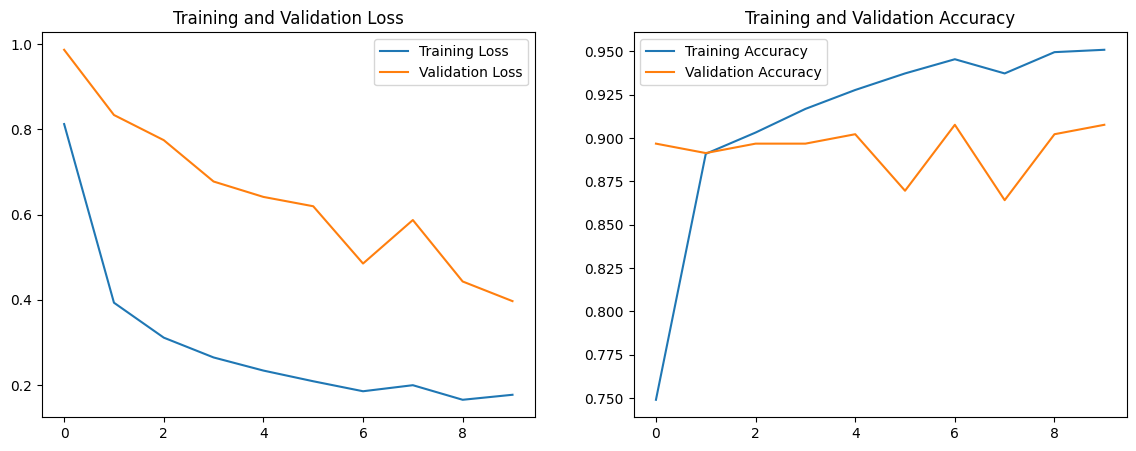

In [12]:
# Plotting loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

6/6 [==============================] - 2s 145ms/step


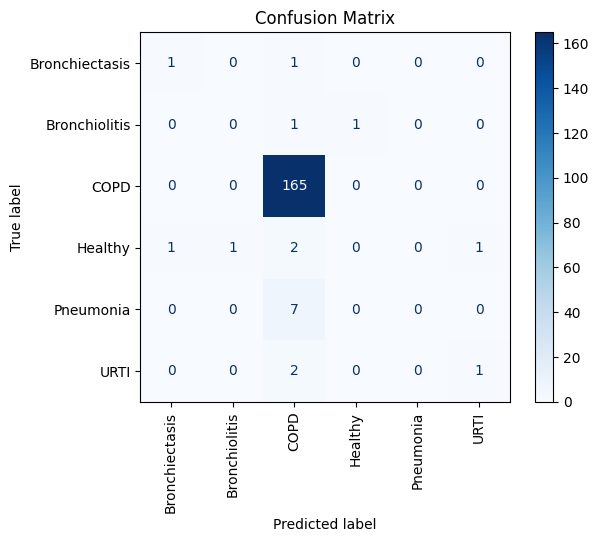

In [13]:
y_pred = model_rnn.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)

# Tampilkan confusion matrix dengan ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.00      0.00      0.00         2
           2       0.93      1.00      0.96       165
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         7
           5       0.50      0.33      0.40         3

    accuracy                           0.91       184
   macro avg       0.32      0.31      0.31       184
weighted avg       0.84      0.91      0.87       184



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
